SAS & HSE, Applied Time Series Forecasitng , Fall 2021 

<font color="blue"> Lesson #7: Loss Functions in Foreasting</font>

<span style="color:black; font-size: 12pt"></span>

Alexey Romanenko,
<font color="blue">alexromsput@gmail.com</font>

**Key words:** 
    - stationary TS, ARMA, ARIMA, ARMAX, SARIMAX, autocorrelcation function,  partial autocorrelation function, exogenious variables,
**Your feedback:**  please provide you feedback  <a href="https://forms.gle/bEV5iwmTqdM9rUoy8"> here </a>

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import stattools
from copy import deepcopy

# don't forget to upload utils file to the colab session
# from utils import qualityMACAPE, qualityRMSE
import warnings
warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

# Loss Functions for Time Series Forecasting 
**Questions**
  * What loss functions for regression tasks do you know?

$$  SSE =\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  MSE =\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $$
$$  RMSE =\sqrt{\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2} $$
$$  MAE =\frac{1}{T}\sum_{t=1}^T  \left|{A_t-F_t}\right| $$
$$  MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| $$
$$  MAPPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{F_t}\right| $$
$$  SMAPE =\frac{2}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t+F_t}\right| $$
$$  MAMAXPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{\max(A_t,F_t)}\right| $$
$$  MASE = \frac{2}{T-R+1} \sum_{t=R}^T \left|\frac{A_t-F_t}{A_t-A_{t-1}}\right| $$
<br></br>
$$  MedianAE = Median \bigl(\left|A_1-F_1\right|,\dots,\left|A_T-F_T\right|\bigr) $$
<br></br>
____________________________________________________________________________
Closer to Business Metrics*
$$  WAPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|A_t\right|} $$
$$  WAPPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|F_t\right|} $$
$$  WAMAXPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\max(\left|A_t\right|,\left|F_t\right| )} $$

* Note: usually, $sum()$ index includes time dimension, as well as organizational dimensions (product, locations, customers, clients, channels, etc.).  

In [105]:
# Quality functions
def qualitySSE(x,y):
    # Sum squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).sum(), (x-y)**2

def qualityMSE(x,y):
    # Mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y)**2).mean() , (x-y)**2

def qualityRMSE(x,y):
    # Root mean squared error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (((x-y)**2).mean())**(0.5) , (x-y).abs()

def qualityMAE(x,y):
    # Mean absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return (x-y).abs().mean(), (x-y).abs()

def qualityMAPE(x,y):
    # Mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/x.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAPPE(x,y):
    # Mean absolute predicted percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/y.abs()).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualitySMAPE(x,y):
    # Symmetric mean absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = (2*(x-y).abs()/(x+y)).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMAMAXPE(x,y):
    # Mean absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/max(x.abs(), y.max())).replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMASE(x,y, init_step=0):
    # Mean absolute scaled error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    qlt = ((x-y).abs()/(x-x.shift(1)).abs())[init_step:].replace([np.inf, -np.inf], np.nan)
    return qlt.mean() , qlt

def qualityMedianAE(x,y):
    # Median absolute error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    return ((x-y).abs()).median(), (x-y).abs()

def qualityWAPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = x.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAPPE(x,y):
    # Weighted absolute percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = y.abs().sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

def qualityWAMAXPE(x,y):
    # Weighted absolute maximum percentage error
    # x,y - pandas structures
    # x - real values
    # y - forecasts
    denom = pd.merge(x, y, right_index = True, left_index = True).max(axis = 1).sum()
    qlt = ((x-y).abs()/denom).replace([np.inf, -np.inf], np.nan)
    return qlt.sum() , qlt

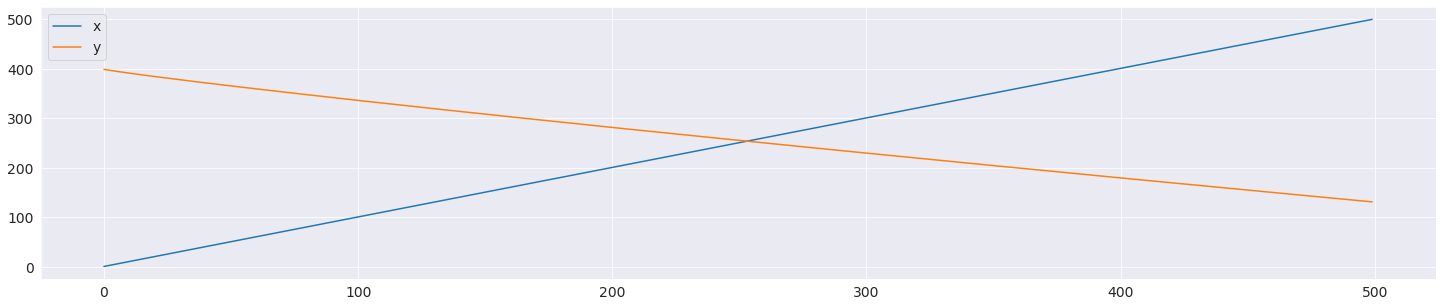

In [117]:
length = 500
frc_ts = pd.DataFrame([[1+x, length-(1+x)**(0.9)-100] for x in range(length)], columns = ['x','y'])
frc_ts.plot()

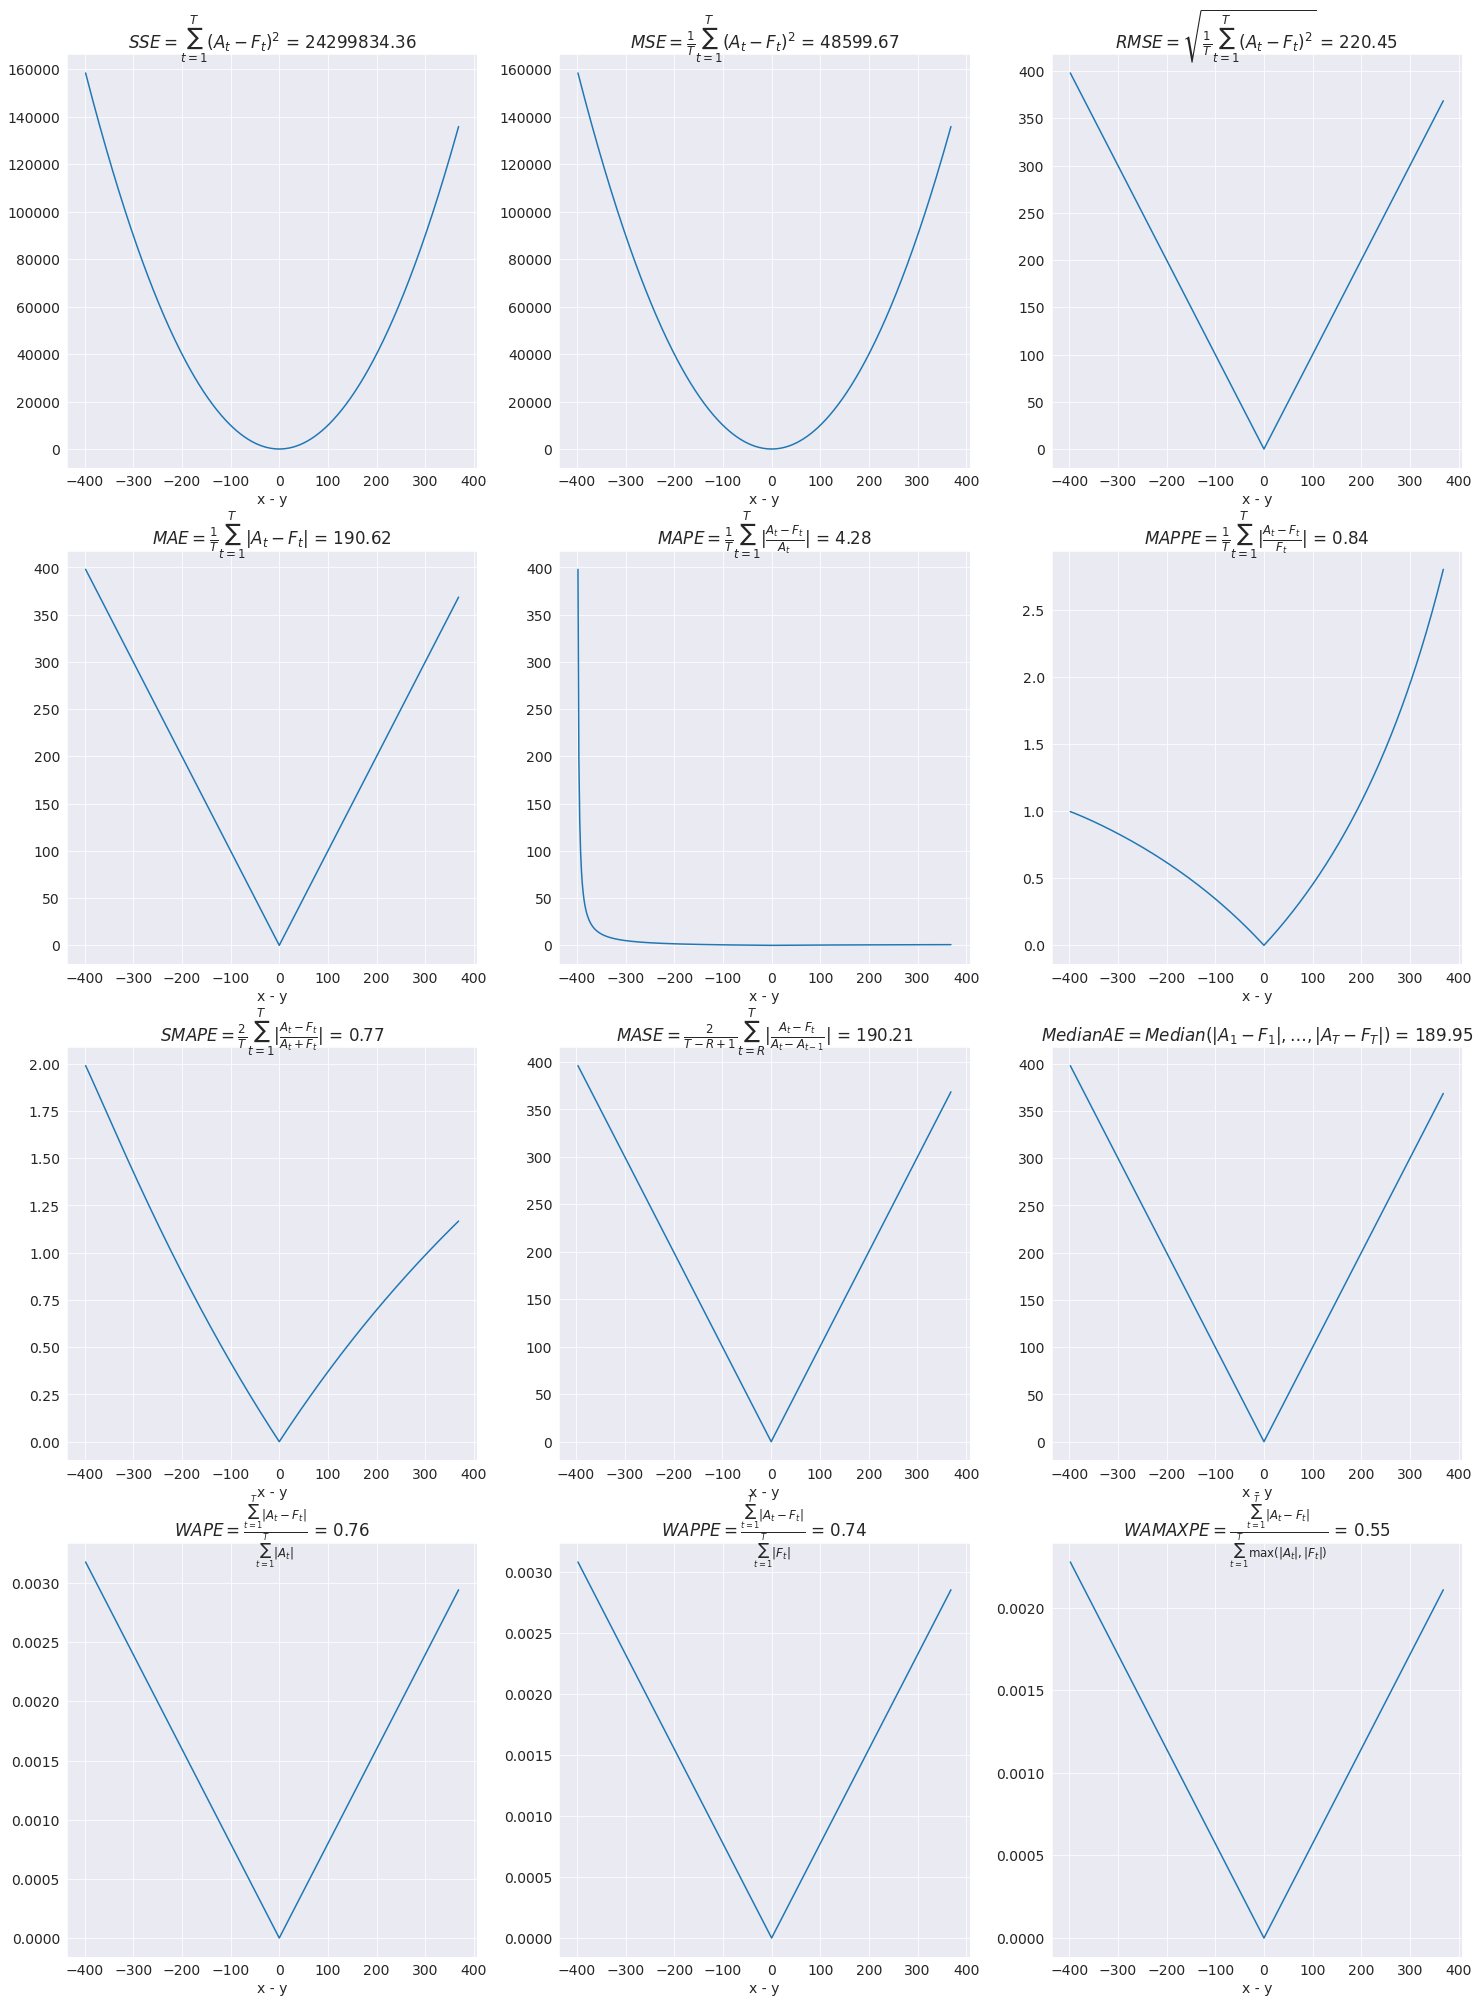

In [118]:
qlt_desc = [r"$SSE =\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $",
r"$MSE =\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2 $",
r"$RMSE =\sqrt{\frac{1}{T}\sum_{t=1}^T  \left({A_t-F_t}\right)^2} $",
r"$MAE =\frac{1}{T}\sum_{t=1}^T  \left|{A_t-F_t}\right| $",
r"$MAPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t}\right| $",
r"$MAPPE =\frac{1}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{F_t}\right| $",
r"$SMAPE =\frac{2}{T}\sum_{t=1}^T  \left|\frac{A_t-F_t}{A_t+F_t}\right| $",
r"$MASE = \frac{2}{T-R+1} \sum_{t=R}^T \left|\frac{A_t-F_t}{A_t-A_{t-1}}\right| $",
r"$MedianAE = Median \left(\left|A_1-F_1\right|,\dots,\left|A_T-F_T\right|\right) $",
r"$WAPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|A_t\right|} $",
r"$WAPPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\left|F_t\right|} $",
r"$WAMAXPE =\frac{\sum_{t=1}^T\left|A_t-F_t\right|}{\sum_{t=1}^T\max(\left|A_t\right|,\left|F_t\right| )} $"]

fig = plt.figure(figsize = (25,35))
ax1=fig.add_subplot(111)
qlt_array=['SSE', 'MSE', 'RMSE', 'MAE', 'MAPE', 'MAPPE', 'SMAPE', 'MASE', 'MedianAE', 'WAPE', 'WAPPE', 'WAMAXPE']
qlt = [np.NaN]*len(qlt_array)
for i in range(len(qlt_array)):
    plt.subplot(4,3,i+1)
    qlt[i], qlt_vec = eval('quality'+qlt_array[i])(frc_ts['x'], frc_ts['y'])
    qlt_vec.index = frc_ts['x']-frc_ts['y']
    qlt_vec.plot(xlabel = 'x - y',  title = '{0} = {1}'.format(qlt_desc[i], round(qlt[i],2)))
    # plt.title(qlt_array[i], y=0.9)

**Let's consider random signal $y_t: {\bf{E}}(y_t, y_{t+\tau}) = 0, \forall \tau>0$**.

Optimal forecast:
$$\hat y^* = \arg\min_{\hat y}\left(\int_{-\infty}^{+\infty}Loss(y, \hat y)\cdot~dy\right)$$

**Questions**:
  * What is the optimal forecast for prediction of such $y_t$?
  * What is the optimal forecast for prediction of such $y_t$ w.r.t. SSE loss function?
  * What is the optimal forecast for prediction of such $y_t$ w.r.t. MAE loss function?
  * What is the optimal forecast for prediction of such $y_t$ w.r.t. MAPE/MAPPE/WAPE/WAPPE/WAMAXPE loss functions?


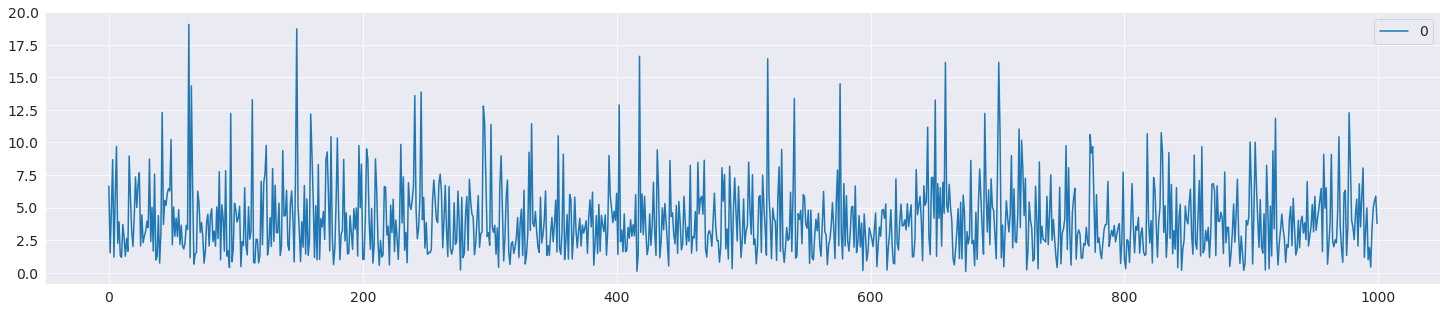

In [120]:
# generate random variable
shape, scale = 2., 2.  # mean=2, std=2*sqrt(2)
y = np.random.gamma(shape, scale, 1000)
pd.DataFrame(y).plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd5062b4550>]],
      dtype=object)

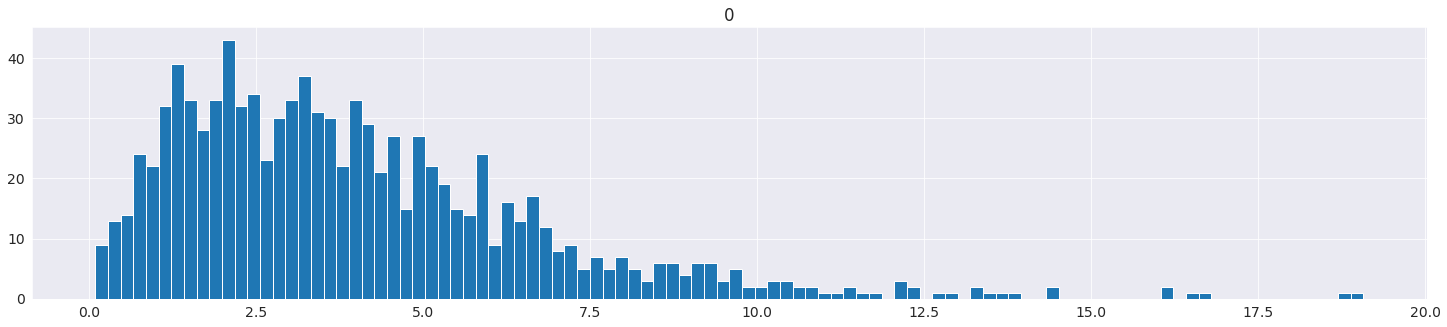

In [135]:
# plot histogramm
pd.DataFrame(y).hist(bins = 100)

In [ ]:
# self-practice task: realize search for optimal value wrt to all loss functions above
[put your code here]

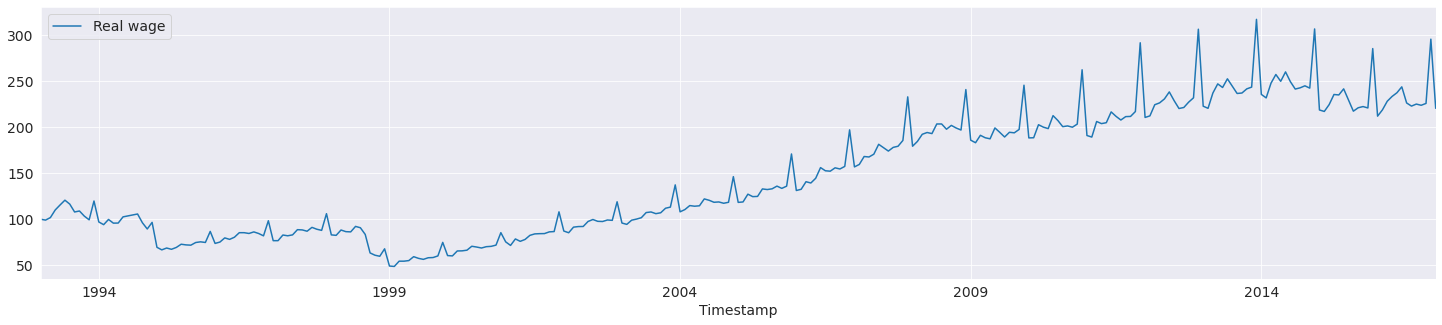

In [ ]:
# Wage
ts_wage = pd.read_csv('https://raw.githubusercontent.com/aromanenko/ATSF/33b78c9be63831567f8036ad40c5859e824d30f7/data/monthly-wage.csv', sep=';', decimal='.', parse_dates=True, index_col='Month')
ts_wage.index.names=['Timestamp']
ts_wage.plot()

# Internal Functional for Regression TS Models

**ML approach to state the problem**

* Definitions
  * $X$ --- feature space ($\mathbb R^n$);
  * $Y$ --- answer space ($\mathbb R$);
  * $X^\ell = (x_i,y_i)_{i=1}^\ell~-$ train samples;
  * $y_i=y(x_i)$,\; $y\colon X\to Y~-$ unknown function;

  * assumption: there is joint distribution $p(x,y)$ for samples from $X^\ell$
  * loss function $\lambda(y_i, \hat y_i): \mathbb R\times \mathbb R\rightarrow [0,+\infty) $

* Learning method is a function: $\mu\colon 2^{X\times Y}\rightarrow \mathfrak{A}$

* loss of algorithm $A=\mu(X^\ell)$:
$$  {Loss}_A = {\mathbf E}_{x,y}\left[ \lambda\left(y, \mu\left(X^\ell\right)\right)\right]$$
  * Estimation of algorithm loss $A=\mu(X^\ell)$

$$ Loss_{A}(X^\ell)=\sum_{i=1}^\ell \lambda\left(y_i, A(x_i)\right) $$

* loss of learning method $\mu$:
$$ {Q}_\mu={\mathbf E}_{X^\ell}\left[Loss_{A} \right] $$

* <font color="red">Main problem of ML is to minimize ${Q}_\mu$</font>

**Question:**
  * Which approaches do you know to calculate ${Q}_\mu$?



**CV approach**

* Hold-out CV: split all data to two sets: $X^\ell=X^{Train}\bigcup X^{Validation}$
<img src = "https://algotrading101.com/learn/wp-content/uploads/2020/06/training-validation-test-data-set.png">


$$ Q_\mu^{CV} (X^\ell) = Q\left(\mu(X^L),X^K\right) = Loss_{\mu(X^L)}\left(X^{K} \right)
$$

**Question**: why testing sample is needed?

<br></br>
* q-fold CV: $X^\ell=X_1^{\ell_1}\bigcup\dots\bigcup X_q^{\ell_q}$

<img src = "https://sebastianraschka.com/images/faq/evaluate-a-model/nested-k-fold.png">
$$
            \mathrm{Q_\mu^{q-fold}}(X^\ell)
            =\frac{1}{q}
            \sum_{i=1}^q
                Q \bigl(\mu \left(X^\ell\!\setminus\!\!\{X^{\ell_i}_i\}\right), X^{\ell_i}_i \bigr)
$$




**AIC (Akaike Information Criterion)**
$$Q_\mu^{AIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{2 \hat\sigma^2}{\ell}\cdot d$$

**BIC (Bayes Information Criterion)**
$$Q_\mu^{BIC}(X^\ell) =  Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\hat\sigma^2\cdot \ln(\ell)}{\ell}\cdot d$$

**HQIC (Hannan–Quinn information criterion)**
$$Q_\mu^{HQIC}(X^\ell) = Q \bigl(\mu \left(X^\ell\right), X^{\ell} \bigr) + \frac{\hat\sigma^2\cdot \ln\ln(\ell)}{\ell}\cdot d$$
  

# Selecting the Best Time Series Forecasting Algorithm


# Conclusion
## Self-check questions
  1. ?
  2. ?
  3. ?
  4. ?
  5. ?
   


**Materialsf**
* Hyndman R.J., Athanasopoulos G. Forecasting: principles and practice,2016. https://www.otexts.org/book/fpp